# <span style="color:#F72585"><center>Construcción automática de texto </center></span>

<center>Introducción</center>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Libro-Fundamentos/main/Tratamiento_de_Lenguaje_Natural/Imagenes/Shakespeare.jpg" width="600" height="600" align="center"/>
</center>
</figure>

Fuente: [Pexels](https://www.pexels.com/es-es/foto/foto-de-la-estatua-de-ceramica-negra-de-perfil-masculino-bajo-un-cielo-gris-durante-el-dia-189532/)

## <span style="color:#4361EE">Introducción</span>

Gran conjunto de datos basado en sonetos de Shakespeare.


## <span style="color:#4361EE">Librerías</span>


In [2]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.11.0


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np 

from tensorflow.keras.utils import plot_model

## <span style="color:#4361EE">Lee los datos</span>

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2022-11-25 18:47:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.250.78.112, 142.250.78.144, 142.250.78.176, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.250.78.112]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 93578 (91K) [text/plain]
Guardando como: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91,38K  --.-KB/s    en 0,06s   

2022-11-25 18:47:16 (1,38 MB/s) - ‘/tmp/sonnets.txt’ guardado [93578/93578]



## <span style="color:#4361EE">Tokeniza el texto</span>


In [5]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

#print('Dictionary: ',tokenizer.word_index,'\n')
print('índice de "rage" = ',tokenizer.word_index['rage'])
print('\nNúmero total de palabras en el Tokenizador (+OOV) =',total_words,'\n')

# Muestra parte del corpus
print('Primeras líneas del corpus: \n')
corpus[0:10]

índice de "rage" =  443

Número total de palabras en el Tokenizador (+OOV) = 3211 

Primeras líneas del corpus: 



['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

## <span style="color:#4361EE">Crea n-Grams para datos de entrenamiento y etiquetas</span>

In [6]:
# crear secuencias de entrada usando una lista de tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
print('input_sequences[0:10] = ',input_sequences[:10],'\n')

# Determine el n-gram más largo
max_seq_test_len = max([len(x) for x in input_sequences])
print('\nlongitud del  n-grama más largo:',max_seq_test_len)


input_sequences[0:10] =  [[34, 417], [34, 417, 877], [34, 417, 877, 166], [34, 417, 877, 166, 213], [34, 417, 877, 166, 213, 517], [8, 878], [8, 878, 134], [8, 878, 134, 351], [8, 878, 134, 351, 102], [8, 878, 134, 351, 102, 156]] 


longitud del  n-grama más largo: 11


### <span style="color:#4CC9F0">¿Qué hizo tokenizer?</span>

In [7]:
line = corpus[0]
token_list = tokenizer.texts_to_sequences([line])
print(line)
print(token_list)
print(token_list[0])

from fairest creatures we desire increase,
[[34, 417, 877, 166, 213, 517]]
[34, 417, 877, 166, 213, 517]


### <span style="color:#4CC9F0">Agrega PAD para tener secuencias de la misma longitud</span>

In [8]:
# secuencias de pad
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# crea predictores y etiqueta
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

In [9]:
print(input_sequences.shape)
print(predictors.shape)
print(label.shape)

(15462, 11)
(15462, 10)
(15462,)


In [10]:
print(len(predictors))
print(len(label))

15462
15462


In [11]:
print(input_sequences[0:3]) # secuencia completa
print('\n')
print(predictors[0:3]) # secuencia hasta el anterior al último
print('\n')
print(label[0:3]) # el último de la secuencia

[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]]


[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]]


[417 877 166]


### <span style="color:#4CC9F0">Convierte etiquetas a one-hot</span>

In [12]:
label = to_categorical(label, num_classes=total_words)
print(label.shape)

(15462, 3211)


## <span style="color:#4361EE">Crea el modelo</span>

In [14]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
print(model.summary())
plot_model(model, to_file='../Imagenes/sonetos.png', 
           show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 300)          301200    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 300)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1605)              162105    
                                                                 
 dense_3 (Dense)             (None, 3211)              5156866   
                                                      

## <span style="color:#4361EE">Entrena</span>

In [16]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 62s 116ms/step - loss: 6.8993 - accuracy: 0.0200
Epoch 2/100
484/484 [==============================] - 55s 114ms/step - loss: 6.5026 - accuracy: 0.0232
Epoch 3/100
484/484 [==============================] - 56s 115ms/step - loss: 6.4065 - accuracy: 0.0244
Epoch 4/100
484/484 [==============================] - 57s 117ms/step - loss: 6.2918 - accuracy: 0.0283
Epoch 5/100
484/484 [==============================] - 57s 118ms/step - loss: 6.1998 - accuracy: 0.0349
Epoch 6/100
484/484 [==============================] - 56s 116ms/step - loss: 6.1202 - accuracy: 0.0376
Epoch 7/100
484/484 [==============================] - 55s 114ms/step - loss: 6.0456 - accuracy: 0.0420
Epoch 8/100
484/484 [==============================] - 56s 117ms/step - loss: 5.9686 - accuracy: 0.0469
Epoch 9/100
484/484 [==============================] - 56s 116ms/step - loss: 5.8782 - accuracy: 0.0519
Epoch 10/100
484/484 [==============================] - 56s 116m

In [22]:
# Guardar history
#np.save('history.npy',history.history)

In [ ]:
# Cargar history
#history = np.load('history.npy',allow_pickle='TRUE').item()

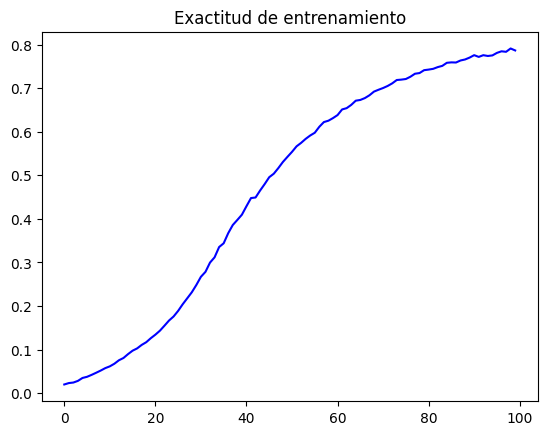

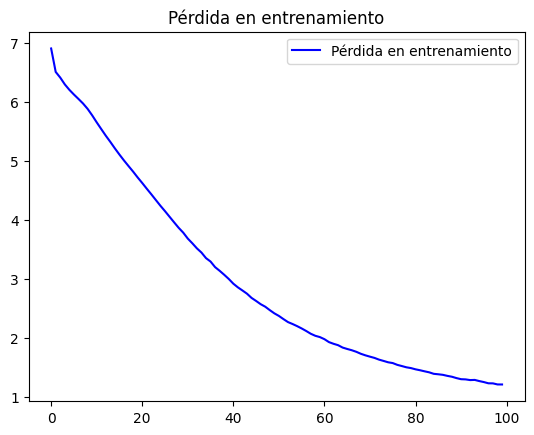

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Exactitud de entrenamiento')
plt.title('Exactitud de entrenamiento')

plt.figure()

plt.plot(epochs, loss, 'b', label='Pérdida en entrenamiento')
plt.title('Pérdida en entrenamiento')
plt.legend()

plt.show()

## <span style="color:#4361EE">Genera texto automáticamente</span>

In [32]:
seed_text = "Who are you, so too cruel?"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_class(token_list, verbose=0)
    predicted = np.argmax(model.predict(token_list),axis=1)
    output_word = ""
    
    print(token_list)
    
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 43ms/step
[[  0   0   0   0  88  41  24  20 135 279]]
1/1 [==============================] - 0s 47ms/step
[[  0   0   0  88  41  24  20 135 279   8]]
1/1 [==============================] - 0s 35ms/step
[[  0   0  88  41  24  20 135 279   8   6]]
1/1 [==============================] - 0s 26ms/step
[[  0  88  41  24  20 135 279   8   6 191]]
1/1 [==============================] - 0s 25ms/step
[[ 88  41  24  20 135 279   8   6 191  24]]
1/1 [==============================] - 0s 28ms/step
[[ 41  24  20 135 279   8   6 191  24 216]]
1/1 [==============================] - 0s 32ms/step
[[ 24  20 135 279   8   6 191  24 216  95]]
1/1 [==============================] - 0s 32ms/step
[[ 20 135 279   8   6 191  24 216  95  95]]
1/1 [==============================] - 0s 30ms/step
[[135 279   8   6 191  24 216  95  95  95]]
1/1 [==============================] - 0s 27ms/step
[[279   8   6 191  24 216  95  95  95  95]]
1/1 [==============================] - 0

¿Quién eres tú, tan cruel? que te sostengo de forma di di di di di que eres más querido ciego 'parece en ti en su maldad mandíbulas de tigre apesta conjunto 'tis hombres sujetos indigestos desfigurados pero algunas barras en el más dulce desgastado sway'st ensayo visto nada dulzura esconderse tanto tiempo lejos pero las palabras parecen buenas ladrón incluso tan bueno desesperación mi sombra cerca de la barra de purga nacido nuevo nuevo mudo muerto sido visto fallecimiento sustancial loco hojas estimado estimado estimado libre visto crecer hombres junio discapacitado creció la mancha del amor todavía en ellos como su enfermedad debe llamarme tener no dos, algunos días sucios terminan la dulzura, comparten 'tis

##   <span style="color:#4361EE">Referencias</span>

1. Basado en el blog de laurencemoroney: (https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt)